In [86]:
import h5py
import matplotlib
import pickle

import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import colorcet as cc

from matplotlib import animation
from IPython.display import Video
from scipy.interpolate import griddata
from matplotlib.gridspec import GridSpec

import skies

%config InlineBackend.figure_format = "retina"

In [2]:
# TODO: Spatial gradients in time
# TODO: Point at target folder
# TODO: Integrate into standard SKIES run
# TODO: Add earthquake events plot to bottom of figure
# TODO: Read only the data for the neccessary time steps at once to reduce memory footprint
# TODO: Contour plot for cumulative coseismic
# TODO: Countour plot for most recent event

# Read in time series, mesh geometry, and mesh evolution

In [3]:
params_file_name = "params.json"
time_series_file_name = "time_series.pickle"
meshes_parameters_file_name = "nankai_mesh_parameters.json"
hdf_filename = "2024_03_22_18_23_31.hdf"
hdf_filename = "2024_03_29_23_04_24.hdf"
hdf_filename = "2024_03_30_11_00_37.hdf"
hdf_filename = "2024_03_30_14_37_28.hdf"
hdf_filename = "2024_03_30_21_10_45.hdf"
hdf_filename = "2024_03_30_23_02_56.hdf"

# Read params
params = skies.get_params(params_file_name)

# Read time series
with open(time_series_file_name, "rb") as f:
    time_series = pickle.load(f)

print(
    f"Start time = {np.min(time_series.real_time)} years, End time = {np.max(time_series.real_time)} years"
)
print(
    f"Time steps = {len(time_series.real_time)}, Time step = {np.diff(time_series.real_time)[0]:0.4f} years = {np.diff(time_series.real_time)[0]*365:0.4f} days "
)


# Read mesh information
meshes = skies.read_meshes(meshes_parameters_file_name)

# Read hdf mesh evolution information
with h5py.File(hdf_filename, "r") as f:
    keys = list(f.keys())
    print(keys)
    for key in keys:
        print(f"{key}: {f[key][()].shape}")

    # Get cumulative slip
    cumulative_slip = f[keys[0]][()]

    # Get geometric moment
    geometric_moment = f[keys[1]][()]

    # Get geometric moment
    loading_rate = f[keys[2]][()]

    # Get location probability
    location_probability = f[keys[3]][()]

location_probability[np.isnan(location_probability)] = 0

Warning: The file contains tag data that couldn't be processed.

Start time = 0.0 years, End time = 5000.0 years
Time steps = 100000, Time step = 0.0500 years = 18.2502 days 
['cumulative_slip', 'geometric_moment', 'loading_rate', 'location_probability']
cumulative_slip: (100000, 1902)
geometric_moment: (100000, 1902)
loading_rate: (1902,)
location_probability: (100000, 1902)


# Constants

In [4]:
frames = len(time_series.real_time)
frames = 100

In [5]:
def plot_meshes(mesh, fill_value, ax, cmap_string):
    x_coords = mesh.meshio_object.points[:, 0]
    y_coords = mesh.meshio_object.points[:, 1]
    vertex_array = np.asarray(mesh.verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts,
        edgecolor="None",
        cmap=cmap_string,
        linewidth=0.0,
        alpha=1.0,
    )
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.gca().set_aspect("equal")
    return pc

# Animate cumulative coseismic slip

In [6]:
fig, ax = plt.subplots()
to_plot = cumulative_slip[0, :]
pc = plot_meshes(meshes[0], to_plot, plt.gca(), cmc.hawaii_r)
plt.colorbar(pc, fraction=0.026, pad=0.04, label="slip (m)")
pc.set_clim(0, 1e1)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=0.25)
plt.gca().set_facecolor("gainsboro")
plt.xlabel("longitude")
plt.ylabel("latitude")


def animate(i):
    pc.set_array(cumulative_slip[i, :])
    pc.set_clim(0, np.max(cumulative_slip[i, :]))
    plt.title(f"time step = {i}, real time = {time_series.real_time[i]:0.3f} (years)")


anim = animation.FuncAnimation(fig, animate, interval=1, frames=frames)
anim.save(filename="cumulative_slip.mp4", writer="ffmpeg", dpi=100)
plt.close("all")
Video("cumulative_slip.mp4", width=500, height=500)

# Interpolated contour plot for accumulated coseismic slip

In [7]:
fig, ax = plt.subplots()
fill_value = cumulative_slip[0, :]
x_vec = np.linspace(params.min_longitude, params.max_longitude, params.n_grid_longitude)
y_vec = np.linspace(params.min_latitude, params.max_latitude, params.n_grid_latitude)
x_mat, y_mat = np.meshgrid(x_vec, y_vec)
centroids_lon = meshes[0].centroids[:, 0]
centroids_lat = meshes[0].centroids[:, 1]
fill_value_mat = griddata(
    (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
)
inpolygon_vals = skies.inpolygon(
    x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(
    inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
)
fill_value_mat[~inpolygon_vals] = np.nan
cmap = cmc.hawaii_r
levels = np.linspace(
    np.min(cumulative_slip[:, :]),
    np.max(cumulative_slip[:, :]),
    50,
)
chf = plt.contourf(
    x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both"
)
plt.colorbar(chf, fraction=0.026, pad=0.04, label="slip (m)")
ch = plt.contour(
    x_mat,
    y_mat,
    fill_value_mat,
    colors="k",
    linestyles="solid",
    linewidths=0.25,
    levels=levels,
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.gca().set_facecolor("gainsboro")
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")


def animate(i):
    global chf
    global ch
    # Remove filled contours
    for c in chf.collections:
        c.remove()
    # Remove line contours
    for c in ch.collections:
        c.remove()

    to_plot = cumulative_slip[i, :]
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), to_plot, (x_mat, y_mat), method="cubic"
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    chf = plt.contourf(
        x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both"
    )
    ch = plt.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    plt.title(
        f"cumulative slip: time step = {i}, real time = {time_series.real_time[i]:0.3f} (years)"
    )


del anim
anim = animation.FuncAnimation(fig, animate, interval=1, frames=frames)
anim.save(filename="cumulative_coseimic_slip_contour.mp4", writer="ffmpeg", dpi=100)
plt.close("all")
Video("cumulative_coseimic_slip_contour.mp4", width=500, height=500)

/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_65947/4007876333.py:28: UserWarning: No contour levels were found within the data range.
  ch = plt.contour(
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_65947/4007876333.py:61: UserWarning: No contour levels were found within the data range.
  ch = plt.contour(


# Interpolated contour plot for geometric moment

In [8]:
fig, ax = plt.subplots()
fill_value = geometric_moment[0, :] / meshes[0].areas
x_vec = np.linspace(params.min_longitude, params.max_longitude, params.n_grid_longitude)
y_vec = np.linspace(params.min_latitude, params.max_latitude, params.n_grid_latitude)
x_mat, y_mat = np.meshgrid(x_vec, y_vec)
centroids_lon = meshes[0].centroids[:, 0]
centroids_lat = meshes[0].centroids[:, 1]
fill_value_mat = griddata(
    (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
)
inpolygon_vals = skies.inpolygon(
    x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(
    inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
)
fill_value_mat[~inpolygon_vals] = np.nan
cmap = cmc.hawaii_r
levels = np.linspace(
    np.min(geometric_moment[:, :] / meshes[0].areas),
    np.max(geometric_moment[:, :] / meshes[0].areas),
    50,
)
chf = plt.contourf(
    x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both"
)
plt.colorbar(chf, fraction=0.026, pad=0.04, label="slip (m)")
ch = plt.contour(
    x_mat,
    y_mat,
    fill_value_mat,
    colors="k",
    linestyles="solid",
    linewidths=0.25,
    levels=levels,
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.gca().set_facecolor("gainsboro")
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")


def animate(i):
    global chf
    global ch
    # Remove filled contours
    for c in chf.collections:
        c.remove()
    # Remove line contours
    for c in ch.collections:
        c.remove()

    to_plot = geometric_moment[i, :] / meshes[0].areas
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), to_plot, (x_mat, y_mat), method="cubic"
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    chf = plt.contourf(
        x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both"
    )
    ch = plt.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    plt.title(
        f"geometric moment: time step = {i}, real time = {time_series.real_time[i]:0.3f} (years)"
    )


del anim
anim = animation.FuncAnimation(fig, animate, interval=1, frames=frames)
anim.save(filename="geometric_moment_contour.mp4", writer="ffmpeg", dpi=100)
plt.close("all")
Video("geometric_moment_contour.mp4", width=500, height=500)

/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_65947/1917290963.py:28: UserWarning: No contour levels were found within the data range.
  ch = plt.contour(
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_65947/1917290963.py:61: UserWarning: No contour levels were found within the data range.
  ch = plt.contour(


# Interpolate contour plot for location probabality

In [156]:
%%time

fig, ax = plt.subplots()
fill_value = location_probability[0, :]
x_vec = np.linspace(params.min_longitude, params.max_longitude, params.n_grid_longitude)
y_vec = np.linspace(params.min_latitude, params.max_latitude, params.n_grid_latitude)
x_mat, y_mat = np.meshgrid(x_vec, y_vec)
centroids_lon = meshes[0].centroids[:, 0]
centroids_lat = meshes[0].centroids[:, 1]
fill_value_mat = griddata(
    (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
)
inpolygon_vals = skies.inpolygon(
    x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(
    inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
)
fill_value_mat[~inpolygon_vals] = np.nan
cmap = cmc.hawaii_r
levels = np.linspace(
    np.min(location_probability),
    np.max(location_probability),
    50,
)

chf = plt.contourf(
    x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both"
)
plt.colorbar(chf, fraction=0.026, pad=0.04, label="probability")
ch = plt.contour(
    x_mat,
    y_mat,
    fill_value_mat,
    colors="k",
    linestyles="solid",
    linewidths=0.25,
    levels=levels,
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.gca().set_facecolor("gainsboro")
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")


def animate(i):
    global chf
    global ch
    # Remove filled contours
    for c in chf.collections:
        c.remove()
    # Remove line contours
    for c in ch.collections:
        c.remove()

    to_plot = location_probability[i, :]
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), to_plot, (x_mat, y_mat), method="cubic"
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    chf = plt.contourf(
        x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both"
    )
    ch = plt.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    plt.title(
        f"location probability: time step = {i}, real time = {time_series.real_time[i]:0.3f} (years)"
    )


del anim
anim = animation.FuncAnimation(fig, animate, interval=1, frames=frames)
anim.save(filename="location_probability_contour.mp4", writer="ffmpeg", dpi=100)
plt.close("all")
# Video("location_probability_contour.mp4", width=500, height=500)

<timed exec>:29: UserWarning:

No contour levels were found within the data range.

<timed exec>:62: UserWarning:

No contour levels were found within the data range.



CPU times: user 1min 23s, sys: 1min 30s, total: 2min 54s
Wall time: 22.9 s


# Multipanel plot
- Two long wide time series plots
    1. Time probability
    2. Event time series

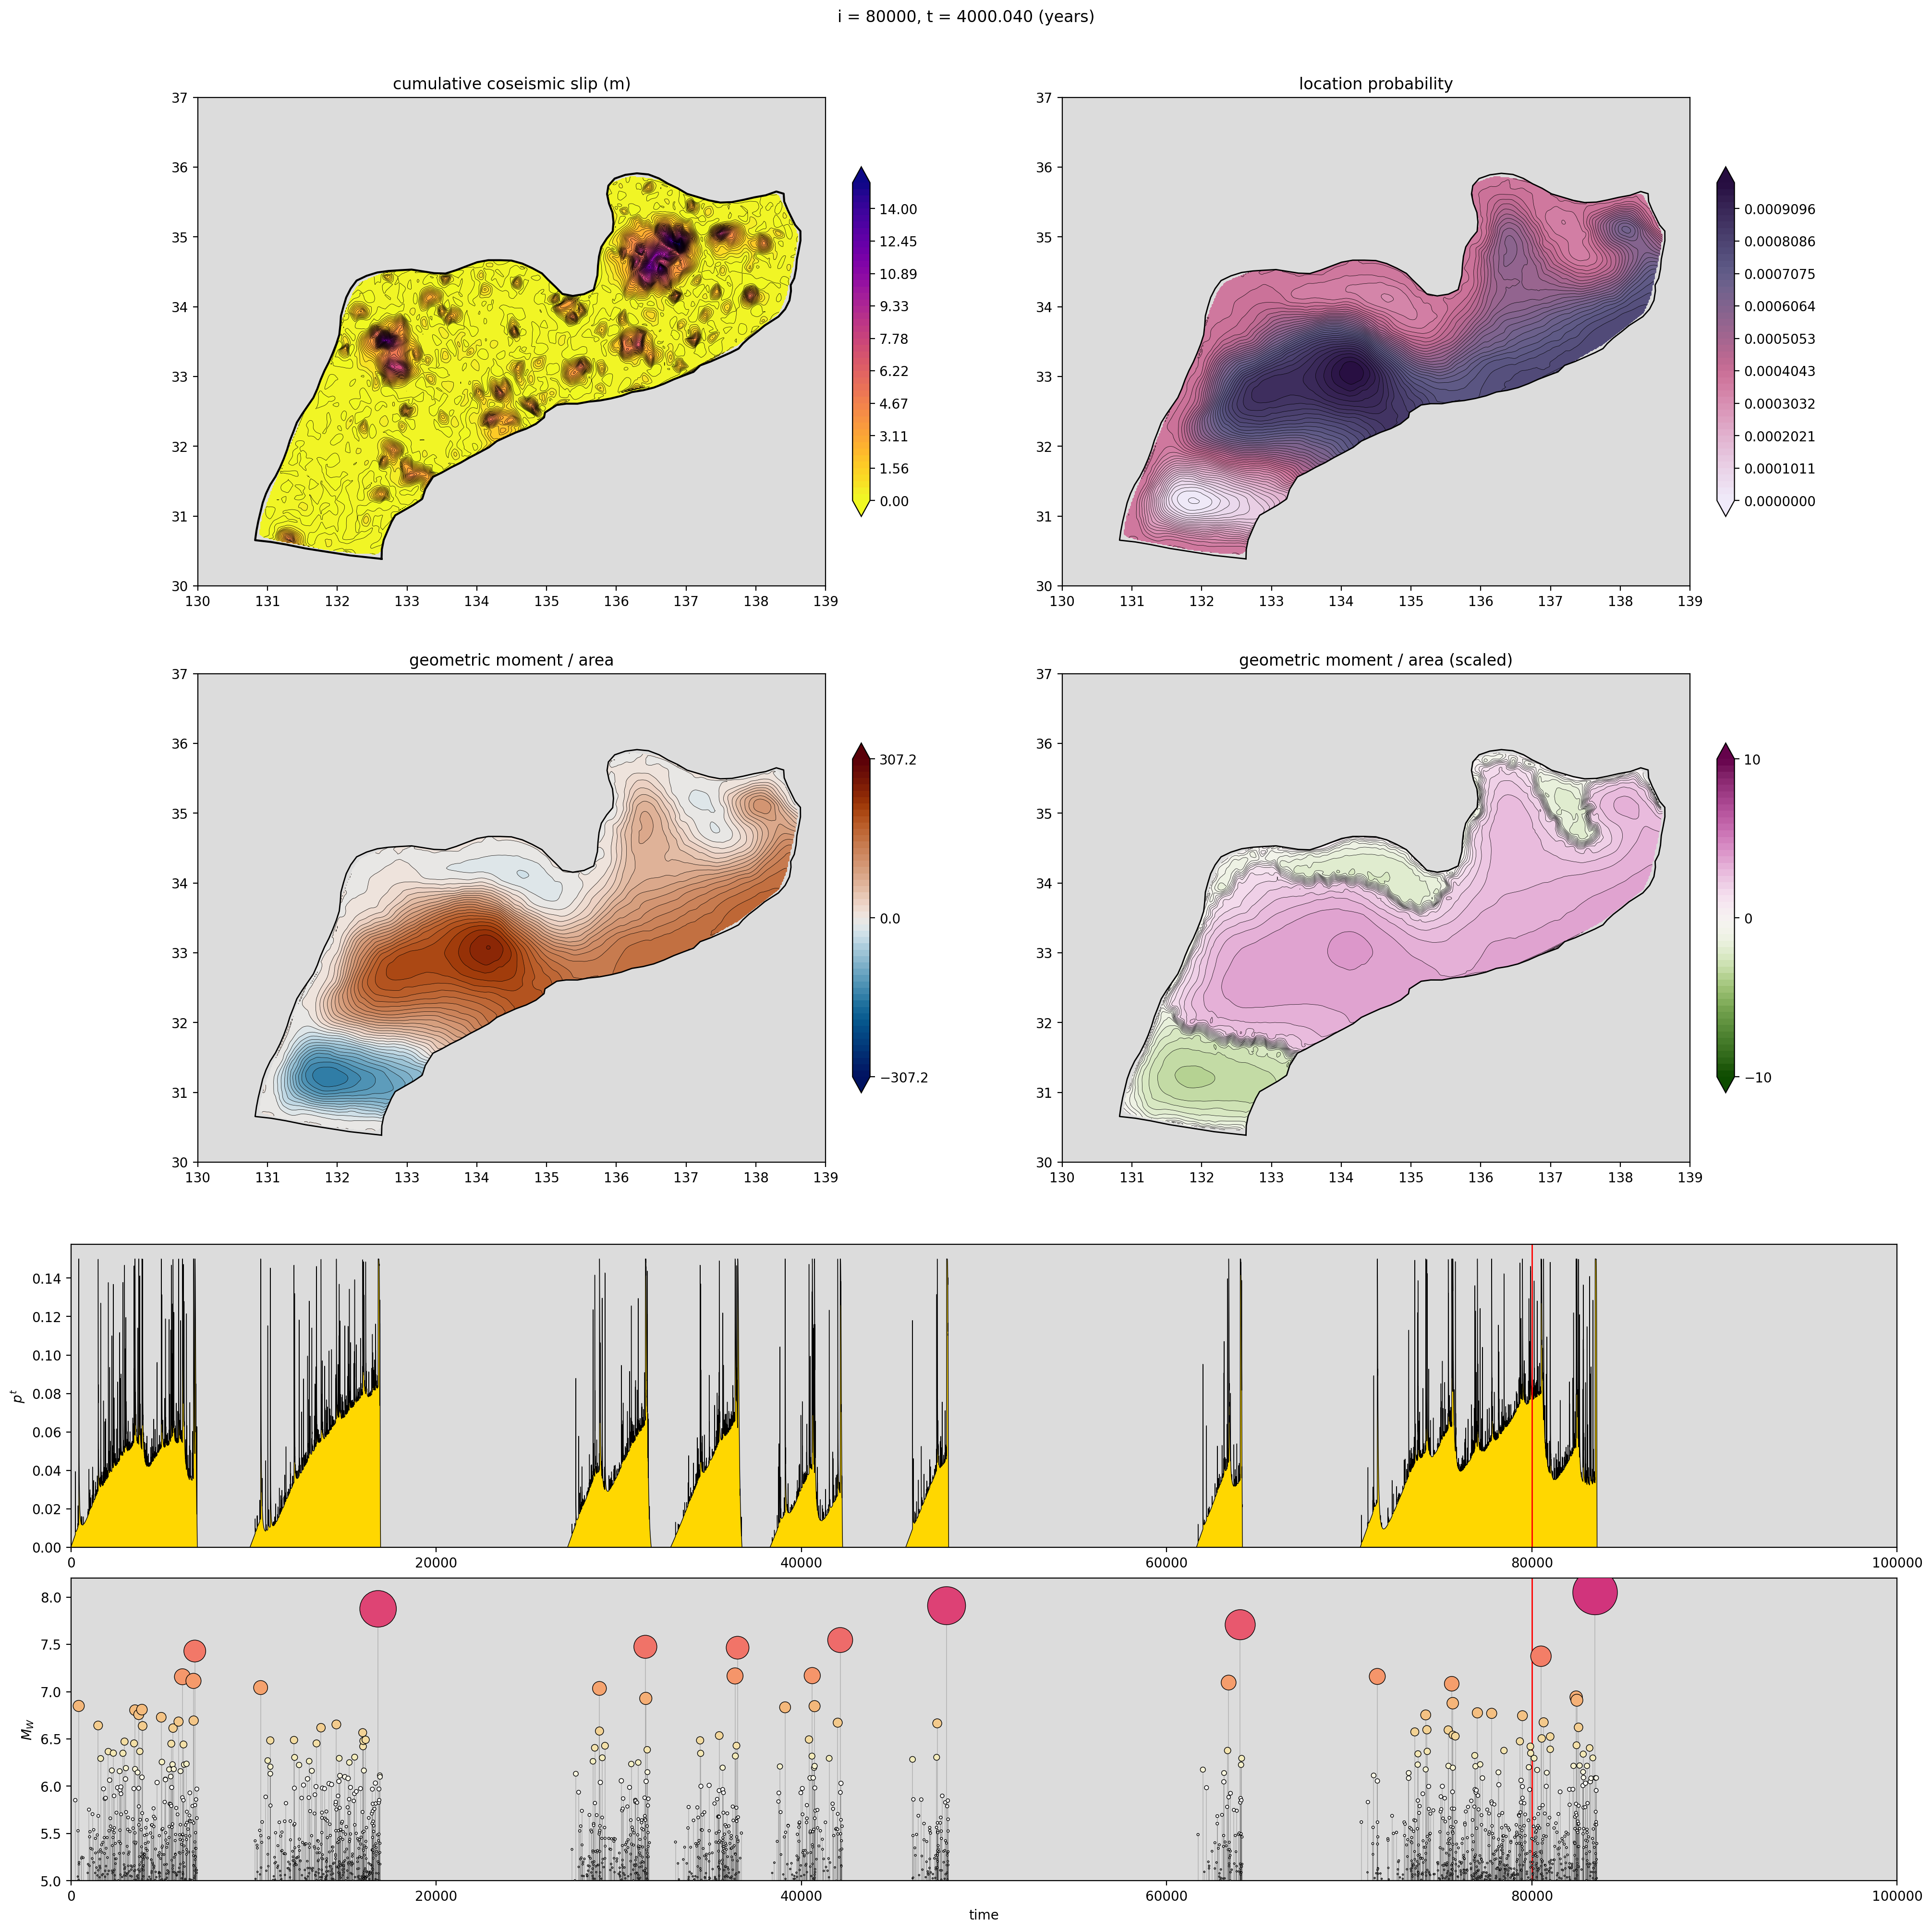

In [181]:
fig = plt.figure(layout="constrained", figsize=(20, 20))
gs = GridSpec(12, 12, figure=fig)
ax1 = fig.add_subplot(gs[10:12, :])
ax2 = fig.add_subplot(gs[8:10, :])
ax3 = fig.add_subplot(gs[0:4, 0:6])
ax4 = fig.add_subplot(gs[0:4, 6:12])
ax5 = fig.add_subplot(gs[4:8, 0:6])
ax6 = fig.add_subplot(gs[4:8, 6:12])

# Refine axis positions
ax3.set_position([0.10, 0.65, 0.35, 0.35])
ax4.set_position([0.55, 0.65, 0.35, 0.35])
ax5.set_position([0.10, 0.35, 0.35, 0.35])
ax6.set_position([0.55, 0.35, 0.35, 0.35])


event_idx = np.where(time_series.event_trigger_flag == 1)[0]
start_idx = 0
end_idx = len(time_series.time)

time_step_index = 80000


# Coseismic event time series (ax1)
for i in range(event_idx.size):
    ax1.plot(
        [
            time_series.time[event_idx[i]],
            time_series.time[event_idx[i]],
        ],
        [
            params.minimum_event_moment_magnitude,
            time_series.event_magnitude[event_idx[i]],
        ],
        "-",
        linewidth=0.1,
        zorder=10,
        color="k",
    )
ax1.scatter(
    time_series.time[event_idx],
    time_series.event_magnitude[event_idx],
    s=1e-5 * 10 ** time_series.event_magnitude[event_idx],
    c=time_series.event_magnitude[event_idx],
    zorder=20,
    alpha=1.0,
    edgecolors="k",
    linewidths=0.5,
    cmap=cc.cm.CET_L17,
    vmin=6.0,
    vmax=9.0,
)
ax1.set_xlim([start_idx, end_idx])
ax1.set_facecolor("gainsboro")
ax1.set_xlabel("time")
ax1.set_ylabel("$M_W$")
ax1.set_ylim(bottom=params.minimum_event_moment_magnitude)
ax1.axvline(x=time_step_index, color="red", linewidth=1.0)


# Coseismic event probability time series (ax2)
ax2.plot(
    time_series.time[start_idx:end_idx],
    time_series.probability_weight[start_idx:end_idx],
    "-k",
    linewidth=0.5,
)
ax2.plot(
    [time_series.time[start_idx], time_series.time[end_idx - 1]],
    [0, 0],
    "-k",
    linewidth=0.5,
)
ax2.fill_between(
    time_series.time[start_idx:end_idx],
    time_series.probability_weight[start_idx:end_idx],
    np.zeros_like(time_series.time[start_idx:end_idx]),
    time_series.probability_weight[start_idx:end_idx] > 0,
    color="gold",
    alpha=1.0,
    edgecolor=None,
)
ax2.set_xlim([start_idx, end_idx])
ax2.set_facecolor("gainsboro")
ax2.set_ylim(bottom=0.0)
ax2.set_ylabel("$p^t$")
ax2.axvline(x=time_step_index, color="red", linewidth=1.0)


# Cumulative coseismic slip (ax3)
fill_value = cumulative_slip[time_step_index, :]
x_vec = np.linspace(params.min_longitude, params.max_longitude, params.n_grid_longitude)
y_vec = np.linspace(params.min_latitude, params.max_latitude, params.n_grid_latitude)
x_mat, y_mat = np.meshgrid(x_vec, y_vec)
centroids_lon = meshes[0].centroids[:, 0]
centroids_lat = meshes[0].centroids[:, 1]
fill_value_mat = griddata(
    (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
)
inpolygon_vals = skies.inpolygon(
    x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(
    inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
)
fill_value_mat[~inpolygon_vals] = np.nan
# cmap = "plasma"
levels = np.linspace(
    np.min(cumulative_slip[:, :]),
    np.max(cumulative_slip[:, :]),
    50,
)
chf = ax3.contourf(
    x_mat, y_mat, fill_value_mat, cmap="plasma_r", levels=levels, extend="both"
)
plt.colorbar(chf, fraction=0.026, pad=0.04, ax=ax3)
ch = ax3.contour(
    x_mat,
    y_mat,
    fill_value_mat,
    colors="k",
    linestyles="solid",
    linewidths=0.25,
    levels=levels,
)
ax3.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
ax3.set_aspect("equal", adjustable="box")
ax3.set_facecolor("gainsboro")
ax3.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
ax3.set_title("cumulative coseismic slip (m)")

# Spatial probability (ax4)
fill_value = location_probability[time_step_index, :]
fill_value_mat = griddata(
    (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
)
fill_value_mat[~inpolygon_vals] = np.nan
cmap = cmc.acton_r
levels = np.linspace(
    np.min(location_probability),
    np.max(location_probability),
    50,
)
chf = ax4.contourf(
    x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both"
)
plt.colorbar(chf, fraction=0.026, pad=0.04, ax=ax4)
ch = ax4.contour(
    x_mat,
    y_mat,
    fill_value_mat,
    colors="k",
    linestyles="solid",
    linewidths=0.25,
    levels=levels,
)
ax4.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
ax4.set_aspect("equal", adjustable="box")
ax4.set_facecolor("gainsboro")
ax4.set_title("location probability")


# Geometric moment (ax5)
fill_value = geometric_moment[time_step_index, :] / meshes[0].areas
vmin = np.min(geometric_moment[:, :] / meshes[0].areas)
vmax = np.max(geometric_moment[:, :] / meshes[0].areas)
if np.abs(vmax) > np.abs(vmin):
    vmin = -vmax
elif np.abs(vmin) > np.abs(vmax):
    vmax = -vmin
fill_value_mat = griddata(
    (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
)
fill_value_mat[~inpolygon_vals] = np.nan
levels = np.linspace(vmin, vmax, 51)
chf = ax5.contourf(
    x_mat, y_mat, fill_value_mat, cmap=cmc.vik, levels=levels, extend="both", vmin=vmin, vmax=vmax
)
plt.colorbar(chf, fraction=0.026, pad=0.04, ax=ax5, ticks=[vmin, 0, vmax])
ch = ax5.contour(
    x_mat,
    y_mat,
    fill_value_mat,
    colors="k",
    linestyles="solid",
    linewidths=0.25,
    levels=levels,
)
ax5.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
ax5.set_aspect("equal", adjustable="box")
ax5.set_facecolor("gainsboro")
ax5.set_title("geometric moment / area")


# Scaled geometric moment (ax6)
fill_value = geometric_moment[time_step_index, :] / meshes[0].areas
fill_value_old = np.copy(fill_value)
fill_value = np.abs(fill_value)
fill_value = fill_value**(0.25)
fill_value = np.sign(fill_value_old) * fill_value
fill_value_mat = griddata(
    (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
)
fill_value_mat[~inpolygon_vals] = np.nan
levels = np.linspace(-10, 10, 50)
chf = ax6.contourf(
    x_mat, y_mat, fill_value_mat, cmap=cmc.bam_r, levels=levels, extend="both", vmin=-10, vmax=10
)
plt.colorbar(chf, fraction=0.026, pad=0.04, ax=ax6, ticks=[-10, 0, 10])
ch = ax6.contour(
    x_mat,
    y_mat,
    fill_value_mat,
    colors="k",
    linestyles="solid",
    linewidths=0.25,
    levels=levels,
)
ax6.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
ax6.set_aspect("equal", adjustable="box")
ax6.set_facecolor("gainsboro")
ax6.set_title("geometric moment / area (scaled)")


# Final steps
plt.suptitle(f"i = {time_step_index}, t = {time_series.real_time[time_step_index]:0.3f} (years)")
plt.show()

In [197]:
for time_step_index in range(80000, 80000 + 5):
    plt.close("all")
    fig = plt.figure(layout="constrained", figsize=(20, 20))
    gs = GridSpec(12, 12, figure=fig)
    ax1 = fig.add_subplot(gs[10:12, :])
    ax2 = fig.add_subplot(gs[8:10, :])
    ax3 = fig.add_subplot(gs[0:4, 0:6])
    ax4 = fig.add_subplot(gs[0:4, 6:12])
    ax5 = fig.add_subplot(gs[4:8, 0:6])
    ax6 = fig.add_subplot(gs[4:8, 6:12])

    # Refine axis positions
    ax3.set_position([0.10, 0.65, 0.35, 0.35])
    ax4.set_position([0.55, 0.65, 0.35, 0.35])
    ax5.set_position([0.10, 0.35, 0.35, 0.35])
    ax6.set_position([0.55, 0.35, 0.35, 0.35])


    # Convenience parameters
    event_idx = np.where(time_series.event_trigger_flag == 1)[0]
    start_idx = 0
    end_idx = len(time_series.time)


    # Coseismic event time series (ax1)
    for i in range(event_idx.size):
        ax1.plot(
            [
                time_series.time[event_idx[i]],
                time_series.time[event_idx[i]],
            ],
            [
                params.minimum_event_moment_magnitude,
                time_series.event_magnitude[event_idx[i]],
            ],
            "-",
            linewidth=0.1,
            zorder=10,
            color="k",
        )
    ax1.scatter(
        time_series.time[event_idx],
        time_series.event_magnitude[event_idx],
        s=1e-5 * 10 ** time_series.event_magnitude[event_idx],
        c=time_series.event_magnitude[event_idx],
        zorder=20,
        alpha=1.0,
        edgecolors="k",
        linewidths=0.5,
        cmap=cc.cm.CET_L17,
        vmin=6.0,
        vmax=9.0,
    )
    ax1.set_xlim([start_idx, end_idx])
    ax1.set_facecolor("gainsboro")
    ax1.set_xlabel("time")
    ax1.set_ylabel("$M_W$")
    ax1.set_ylim(bottom=params.minimum_event_moment_magnitude)
    ax1.axvline(x=time_step_index, color="red", linewidth=1.0)


    # Coseismic event probability time series (ax2)
    ax2.plot(
        time_series.time[start_idx:end_idx],
        time_series.probability_weight[start_idx:end_idx],
        "-k",
        linewidth=0.5,
    )
    ax2.plot(
        [time_series.time[start_idx], time_series.time[end_idx - 1]],
        [0, 0],
        "-k",
        linewidth=0.5,
    )
    ax2.fill_between(
        time_series.time[start_idx:end_idx],
        time_series.probability_weight[start_idx:end_idx],
        np.zeros_like(time_series.time[start_idx:end_idx]),
        time_series.probability_weight[start_idx:end_idx] > 0,
        color="gold",
        alpha=1.0,
        edgecolor=None,
    )
    ax2.set_xlim([start_idx, end_idx])
    ax2.set_facecolor("gainsboro")
    ax2.set_ylim(bottom=0.0)
    ax2.set_ylabel("$p^t$")
    ax2.axvline(x=time_step_index, color="red", linewidth=1.0)


    # Cumulative coseismic slip (ax3)
    fill_value = cumulative_slip[time_step_index, :]
    x_vec = np.linspace(params.min_longitude, params.max_longitude, params.n_grid_longitude)
    y_vec = np.linspace(params.min_latitude, params.max_latitude, params.n_grid_latitude)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    inpolygon_vals = skies.inpolygon(
        x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(
        inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    # cmap = "plasma"
    levels = np.linspace(
        np.min(cumulative_slip[:, :]),
        np.max(cumulative_slip[:, :]),
        50,
    )
    chf = ax3.contourf(
        x_mat, y_mat, fill_value_mat, cmap="plasma_r", levels=levels, extend="both"
    )
    plt.colorbar(chf, fraction=0.026, pad=0.04, ax=ax3)
    ch = ax3.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    ax3.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    ax3.set_aspect("equal", adjustable="box")
    ax3.set_facecolor("gainsboro")
    ax3.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    ax3.set_title("cumulative coseismic slip (m)")

    # Spatial probability (ax4)
    fill_value = location_probability[time_step_index, :]
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    cmap = cmc.acton_r
    levels = np.linspace(
        np.min(location_probability),
        np.max(location_probability),
        50,
    )
    chf = ax4.contourf(
        x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both"
    )
    plt.colorbar(chf, fraction=0.026, pad=0.04, ax=ax4)
    ch = ax4.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    ax4.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    ax4.set_aspect("equal", adjustable="box")
    ax4.set_facecolor("gainsboro")
    ax4.set_title("location probability")


    # Geometric moment (ax5)
    fill_value = geometric_moment[time_step_index, :] / meshes[0].areas
    vmin = np.min(geometric_moment[:, :] / meshes[0].areas)
    vmax = np.max(geometric_moment[:, :] / meshes[0].areas)
    if np.abs(vmax) > np.abs(vmin):
        vmin = -vmax
    elif np.abs(vmin) > np.abs(vmax):
        vmax = -vmin
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    levels = np.linspace(vmin, vmax, 51)
    chf = ax5.contourf(
        x_mat, y_mat, fill_value_mat, cmap=cmc.vik, levels=levels, extend="both", vmin=vmin, vmax=vmax
    )
    plt.colorbar(chf, fraction=0.026, pad=0.04, ax=ax5, ticks=[vmin, 0, vmax])
    ch = ax5.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    ax5.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    ax5.set_aspect("equal", adjustable="box")
    ax5.set_facecolor("gainsboro")
    ax5.set_title("geometric moment / area")


    # Scaled geometric moment (ax6)
    fill_value = geometric_moment[time_step_index, :] / meshes[0].areas
    fill_value_old = np.copy(fill_value)
    fill_value = np.abs(fill_value)
    fill_value = fill_value**(0.25)
    fill_value = np.sign(fill_value_old) * fill_value
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    levels = np.linspace(-10, 10, 50)
    chf = ax6.contourf(
        x_mat, y_mat, fill_value_mat, cmap=cmc.bam_r, levels=levels, extend="both", vmin=-10, vmax=10
    )
    plt.colorbar(chf, fraction=0.026, pad=0.04, ax=ax6, ticks=[-10, 0, 10])
    ch = ax6.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    ax6.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    ax6.set_aspect("equal", adjustable="box")
    ax6.set_facecolor("gainsboro")
    ax6.set_title("geometric moment / area (scaled)")


    # Final steps
    plt.suptitle(f"{hdf_filename[:-4]}, i = {time_step_index}, t = {time_series.real_time[time_step_index]:0.3f} (years)")
    png_file_name = f"{hdf_filename[:-4]}_{time_step_index:010}.png"
    plt.savefig(png_file_name, dpi=200)
    plt.close("all")
    # plt.show()